## AMMI PROJECT
## Model Performance Analysis

In [ ]:
! pip install --upgrade pip setuptools wheel
! pip install --index https://pypi.voxel51.com fiftyone

In [35]:
! pip install detecto
! pip install torch, torchvision

In [1]:
import fiftyone as fo
import fiftyone.brain as fob
import detecto
from detecto.core import Model
from detecto.utils import read_image
import torch
import torchvision

In [2]:
# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ["House", "Car", "Ongoing Construction", "Built-up area", "Water Storage", "Bus", "Truck", "Train Track"]

## Qualitative Analysis

## Load trained  Model for Analysis

In [36]:
# Load a pre-trained Faster R-CNN model
model = Model.load('/home/emmanuel/ammi_ml-proj/model.pth', labels)
print(model, ":Model ready")

<detecto.core.Model object at 0x7f446c290c18> :Model ready


## Load test dataset 

In [37]:
name = "object-detection_Project"
dataset_dir = "/home/emmanuel/ammi_ml-proj/dataset/"

# Create the dataset
dataset = fo.Dataset.from_dir(dataset_dir, fo.types.VOCDetectionDataset, name=name
)

 100% |██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [87.2ms elapsed, 0s remaining, 103.2 samples/s]     


## Compute Dataset Uniqueness ( please change port on each run)

In [ ]:
fob.compute_uniqueness(dataset)
dups_view = dataset.sort_by("uniqueness")
# Launch the App
session = fo.launch_app(view=dups_view, port=7080)

## Select rondomly test images to use and make predictions on them

In [38]:
predictions_view = dataset.take(9, seed=45)

In [40]:
from PIL import Image
from detecto.utils import read_image
from torchvision.transforms import functional as func

In [41]:
# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        image = read_image(sample.filepath)


        labels, boxes, scores = model.predict([image])[0]
        
        scores = scores.detach().numpy()
        boxes = boxes.detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(fo.Detection(
                label=label,
                bounding_box=rel_box,
                confidence=score
            ))

        # Save predictions to dataset
        sample["model"] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")

 100% |██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [35.8s elapsed, 0s remaining, 0.3 samples/s]       
Finished adding predictions


## Select predictions greater than 0.55 confidence 

In [42]:
from fiftyone import ViewField as F

# Only keep detections with confidence > 0.55
high_conf_view = predictions_view.filter_detections("model", F("confidence") > 0.55)

In [43]:
sample = high_conf_view.first()
print(sample.model.detections[0])

<Detection: {
    'id': '5fc62ac227871c3a7c5b6744',
    '_id': '5fc62ac227871c3a7c5b6744',
    'attributes': BaseDict({}),
    'label': 'House',
    'bounding_box': BaseList([
        0.1947205596499973,
        0.40360496662281176,
        0.13765078120761448,
        0.13736399897822626,
    ]),
    'mask': None,
    'confidence': 0.9840937256813049,
    'index': None,
    '_cls': 'Detection',
}>


In [44]:
print(predictions_view)

Dataset:        object-detection_Project
Media type:     image
Num samples:    9
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    model:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
Pipeline stages:
    1. Take(size=9, seed=45)


## View result to compare predictions and ground truth (please change port on each run)

In [45]:
! sudo sysctl kernel.unprivileged_userns_clone=1

# Open the dataset in the App
session = fo.launch_app(dataset=dataset, port=7050) 
# Load view containing the subset of samples for which we added predictions
session.view = predictions_view  

[sudo] password for emmanuel: 
App launched


## Quantitative analysis

## Load model and test data

In [3]:
from detecto.core import Model

In [4]:
model = Model.load("/home/emmanuel/ammi_ml-proj/model.pth", classes)

In [5]:
from detecto.utils import xml_to_csv
from detecto.core import Dataset
from detecto.visualize import plot_prediction_grid

In [6]:
xml_to_csv('/home/emmanuel/ammi_ml-proj/test_labels_selected/', 'test_s_labels.csv')
test_dataset_selected = Dataset('test_s_labels.csv', '/home/emmanuel/ammi_ml-proj/test_seleted/')

In [21]:
images = []
for i in range(1):
    image, _ = test_dataset_selected[i]
    images.append(image)

## Predict on on test image

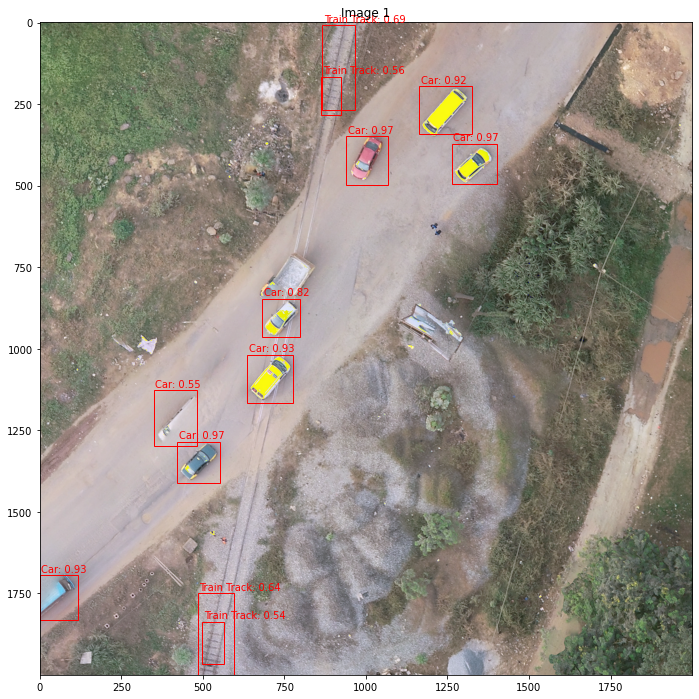

In [22]:
plot_prediction_grid(model, images, dim=(1, 1), figsize=(12, 12), score_filter=0.5)

## Get predicted boxes and scores

In [23]:
# Selecting the images at from the test dataset for quantitative anlysis

image1 = read_image("/home/emmanuel/ammi_ml-proj/test_seleted/IMG_160729_071411_0010_RGB.JPG")
image2 = read_image("/home/emmanuel/ammi_ml-proj/test_seleted/IMG_160729_071414_0011_RGB.JPG")
image3 = read_image("/home/emmanuel/ammi_ml-proj/test_seleted/tile_28000_8000.tif")
image4 = read_image("/home/emmanuel/ammi_ml-proj/test_seleted/tile_30000_6000.tif")

In [32]:
## get predicted boxes and scores

labels, boxes, scores = model.predict(image4)

## Ground truth and predicated localization

In [35]:
#GT Boxes image1
gt_boxes_0010= {"IMG_160729_071411_0010_RGB.JPG": [[1145, 825, 1640, 1104], 
                                                   [2158, 230, 3649, 747],
                                                   [2184, 1243, 2753, 1786],
                                                   [1684, 1278, 1914, 1651]
                                                  ]}

#Pred Boxes image1
pred_boxes_0010={"IMG_160729_071411_0010_RGB.JPG": {"boxes": [[1167.9222,  828.6606, 1620.9156, 1100.8018], 
                                       [2115.4202,  228.5508, 3656.2209,  749.3742], 
                                       [2185.1985, 1257.3813, 2750.5906, 1706.6943], 
                                       [1670.8680, 1270.2533, 1877.4886, 1651.4200], 
                                       [1138.9893,    0.0000, 4594.4580, 3273.9204], 
                                       [2000.7773,   46.5853, 4193.9312, 2466.8411], 
                                       [  33.3411,    0.0000, 3310.0952, 3333.5425], 
                                       [1542.9091, 1254.6191, 1903.8264, 1700.2260], 
                                       [1661.1843, 1252.8008, 2064.9292, 1702.8033], 
                                       [ 391.8965,    0.0000, 4494.8188, 1472.9171], 
                                       [1954.0569, 2370.8481, 2153.6614, 2826.5967]],                                  
                             "scores": [0.9949, 0.9936, 0.9914, 0.9878, 0.3193, 0.2154, 0.1383, 0.0939, 0.0867, 0.0664, 0.0649]}}

In [36]:
gt_bboxes_0010 = [[1145, 825, 1640, 1104],
                  [2158, 230, 3649, 747],
                  [2184, 1243, 2753, 1786], 
                  [1684, 1278, 1914, 1651]]

pred_bboxes_0010 = [[1167.9222,  828.6606, 1620.9156, 1100.8018],
                    [2115.4202,  228.5508, 3656.2209,  749.3742],
                    [2185.1985, 1257.3813, 2750.5906, 1706.6943],
                    [1670.8680, 1270.2533, 1877.4886, 1651.4200],
                    [1138.9893, 0.0000, 4594.4580, 3273.9204], 
                    [2000.7773,46.5853, 4193.9312, 2466.8411], 
                    [33.3411, 0.0000, 3310.0952, 3333.5425], 
                    [1542.9091, 1254.6191, 1903.8264, 1700.2260], 
                    [1661.1843, 1252.8008, 2064.9292, 1702.8033], 
                    [391.8965, 0.0000, 4494.8188, 1472.9171], 
                    [1954.0569, 2370.8481, 2153.6614, 2826.5967]]

In [37]:
#GT Boxes image2
gt_boxes_0011= {"IMG_160729_071414_0011_RGB.JPG": [[2336, 1256, 3962, 1895], 
                                                   [2445, 2504, 3171, 3104],
                                                   [1345, 1991, 1845, 2269],
                                                   [1923, 2512, 2127, 2951]
                                                  ]}

#Pred Boxes image2
pred_boxes_0011={"IMG_160729_071414_0011_RGB.JPG": {"boxes": [[2473.7100, 2512.7646, 3125.9250, 3047.8313],
                                        [1348.6954, 2002.0223, 1837.5677, 2274.3542],
                                        [2341.2961, 1293.6305, 3967.3721, 1883.9786],
                                        [1915.0946, 2490.5515, 2123.8425, 2934.6240],
                                        [1181.5649, 1078.4656, 4285.8481, 3456.0002],
                                        [2146.8372,  136.3202, 4607.9995, 3193.0605],
                                        [1731.5331, 2480.0576, 2161.5049, 2955.2603],
                                        [2290.4829, 1266.9658, 3944.7532, 1891.4545]],                                  
                             "scores": [0.9942, 0.9929, 0.9870, 0.9783, 0.4939, 0.1215, 0.0765, 0.0611]}}

In [38]:
gt_bboxes_0011 = [[2336, 1256, 3962, 1895], 
                  [2445, 2504, 3171, 3104],
                  [1345, 1991, 1845, 2269],
                  [1923, 2512, 2127, 2951]]

pred_bboxes_0011 = [[2473.7100, 2512.7646, 3125.9250, 3047.8313],
                    [1348.6954, 2002.0223, 1837.5677, 2274.3542],
                    [2341.2961, 1293.6305, 3967.3721, 1883.9786],
                    [1915.0946, 2490.5515, 2123.8425, 2934.6240],
                    [1181.5649, 1078.4656, 4285.8481, 3456.0002],
                    [2146.8372,  136.3202, 4607.9995, 3193.0605],
                    [1731.5331, 2480.0576, 2161.5049, 2955.2603],
                    [2290.4829, 1266.9658, 3944.7532, 1891.4545]]

In [39]:
#GT Boxes image3
gt_boxes_28000_8000= {"tile_28000_8000.tif": [[496, 1713, 597, 2000], 
                                              [869, 1, 970, 286],
                                              [788, 339, 889, 625],
                                              [567, 1387, 668, 1673],
                                              [420, 1294, 555, 1401],
                                              [650, 1038, 767,1153],
                                              [675, 715, 859, 840],
                                              [950, 347, 1055, 503],
                                              [1278, 372, 1390, 501],
                                              [1184, 199, 1294, 330],
                                              [3, 1703, 100, 1822]
                                             ]}

#Pred Boxes image3
pred_boxes_28000_8000={"tile_28000_8000.tif": {"boxes": [[1262.7849,  371.5912, 1403.0817,  494.4541],
                                            [ 939.3569,  347.7869, 1067.0596,  496.5326],
                                            [ 421.8829, 1284.6155,  552.4462, 1411.8658],
                                            [   0.0000, 1694.9329,  117.5475, 1832.0441],
                                            [ 636.8693, 1017.9128,  777.4921, 1167.0255],
                                            [1162.8879,  194.4612, 1325.0002,  340.7257],
                                            [ 681.7352,  847.3833,  797.3687,  964.1623],
                                            [ 866.7396,    8.2943,  965.2495,  267.8353],
                                            [ 484.8182, 1749.4509,  595.7650, 2000.0000],
                                            [ 863.4503,  165.4916,  923.3804,  282.5186],
                                            [ 349.2130, 1126.7742,  481.3049, 1298.3087],
                                            [ 498.8125, 1837.6934,  565.0045, 1966.5870],
                                            [ 874.7608,  130.1707,  931.6724,  252.3872],
                                            [ 889.9736,   16.4256,  951.8710,  147.2316],
                                            [ 884.3187,   91.5658,  940.5661,  225.2732],
                                            [ 662.7855,  703.5836,  855.3055,  849.1379],
                                            [ 863.5331,  195.6697,  929.7967,  248.4335],
                                            [ 508.4899, 1637.8566,  613.0081, 1906.8263],
                                            [ 856.3712,  194.0796,  913.0258,  324.0089],
                                            [ 856.3480,  114.2673,  942.2509,  344.0994],
                                            [ 501.6568, 1824.3361,  583.2751, 1919.9797],
                                            [ 472.1906, 1843.4414,  575.1832, 2000.0000],
                                            [ 882.5447,   79.2309,  956.8739,  178.9150],
                                            [ 859.6655,  210.5753,  928.5056,  267.6070],
                                            [ 534.6012, 1664.6840,  612.6076, 1758.0535],
                                            [ 880.5641,   59.4107,  960.2855,  120.8284],
                                            [ 523.0992, 1732.2058,  598.9172, 1824.8679],
                                            [ 584.5544, 1393.8564,  677.0543, 1651.4807],
                                            [ 489.5507, 1875.7802,  581.9741, 1941.3191],
                                            [ 528.1332, 1704.0615,  602.0712, 1795.5267],
                                            [ 490.0155, 1880.8816,  548.9033, 1987.2593],
                                            [ 838.9106,    0.0000,  996.0255,  361.3195],
                                            [ 472.8043, 1630.8296,  643.0007, 2000.0000],
                                            [ 864.3574,  166.7075,  947.4708,  231.5173],
                                            [ 516.0275, 1782.0319,  590.0775, 1877.9336],
                                            [ 858.9651,  228.6870,  923.4193,  286.8767],
                                            [ 845.4822,  166.0414,  925.9702,  392.8218],
                                            [ 490.8276, 1896.5741,  574.1516, 1959.5911],
                                            [ 877.8547,  136.6597,  954.6115,  201.0150],
                                            [ 598.8953, 1491.8322,  670.4412, 1582.9438],
                                            [ 828.6266,  229.6620,  909.1898,  484.3162],
                                            [ 866.1743,    4.5265,  964.9148,  121.4653],
                                            [ 622.2589, 1408.1162,  672.6282, 1533.3145],
                                            [ 852.1927,  253.4423,  903.9420,  400.3567],
                                            [ 610.2959, 1439.0416,  660.8210, 1570.7808],
                                            [ 848.2397,  238.2413,  920.7933,  337.9398],
                                            [ 509.9131, 1629.2650,  635.9141, 1793.0278],
                                            [ 809.0374,  285.0343,  888.7139,  586.3165],
                                            [ 674.8673,  710.1781,  845.5817,  850.9401],
                                            [ 493.6395, 1925.4768,  541.9117, 1998.9244],
                                            [ 681.4611,  715.4128,  842.9851,  853.8015],
                                            [ 601.0824, 1300.6550,  690.9430, 1596.9933],
                                            [ 100.9747,   10.4901, 1879.2914, 1973.7717],
                                            [ 472.7694, 1814.1729,  624.7738, 1952.4486],
                                            [ 571.6705, 1470.0239,  670.9167, 1729.4512],
                                            [1101.3795,  852.1719, 1295.2452, 1017.9343],
                                            [ 660.4123,  702.6687,  847.4889,  858.2739],
                                            [ 484.9593, 1924.2227,  564.6095, 1981.2681],
                                            [ 580.6011, 1496.2792,  694.4117, 1636.0237],
                                            [1097.9851,  851.0564, 1284.8383, 1015.8572],
                                            [ 793.8211,  349.7690,  875.5992,  653.2880],
                                            [ 837.8989,  252.9518,  939.2629,  406.4166],
                                            [ 348.1594, 1133.9357,  492.5201, 1303.5973],
                                            [ 623.4510,  977.8013,  814.6626, 1207.0629],
                                            [1099.9258,  850.0881, 1288.9509, 1019.1448],
                                            [ 627.1916, 1367.7712,  676.2991, 1502.1216],
                                            [ 645.1061, 1047.4580,  761.5807, 1312.5245],
                                            [ 638.7977,  997.4493,  771.5911, 1298.1505],
                                            [1246.7775,  319.9758, 1417.1650,  526.6999],
                                            [1103.9290,  861.4084, 1291.7830, 1020.7897],
                                            [ 602.8580, 1395.5785,  713.9050, 1545.9297]],                                  
                             "scores": [0.9706, 0.9678, 0.9674, 0.9319, 0.9301, 0.9155, 0.8194, 0.6893, 0.6359,
                                            0.5569, 0.5542, 0.5360, 0.4939, 0.4649, 0.4563, 0.4356, 0.4291, 0.4063,
                                            0.4045, 0.3789, 0.3661, 0.3654, 0.3647, 0.3559, 0.3379, 0.3181, 0.3107,
                                            0.3024, 0.2979, 0.2925, 0.2910, 0.2841, 0.2806, 0.2784, 0.2658, 0.2600,
                                            0.2600, 0.2462, 0.2336, 0.2002, 0.1974, 0.1947, 0.1870, 0.1782, 0.1754,
                                            0.1535, 0.1483, 0.1417, 0.1406, 0.1323, 0.1244, 0.1237, 0.1220, 0.1177,
                                            0.1121, 0.1099, 0.1083, 0.0907, 0.0892, 0.0833, 0.0776, 0.0701, 0.0675,
                                            0.0600, 0.0582, 0.0581, 0.0554, 0.0546, 0.0523, 0.0503, 0.0503]}}

In [40]:
gt_bboxes_28000_8000 = [[496, 1713, 597, 2000], 
                        [869, 1, 970, 286],
                        [788, 339, 889, 625],
                        [567, 1387, 668, 1673],
                        [420, 1294, 555, 1401],
                        [650, 1038, 767,1153],
                        [675, 715, 859, 840],
                        [950, 347, 1055, 503],
                        [1278, 372, 1390, 501],
                        [1184, 199, 1294, 330],
                        [3, 1703, 100, 1822]]

pred_bboxes_28000_8000 = [[1262.7849,  371.5912, 1403.0817,  494.4541],
                          [ 939.3569,  347.7869, 1067.0596,  496.5326],
                          [ 421.8829, 1284.6155,  552.4462, 1411.8658],
                            [   0.0000, 1694.9329,  117.5475, 1832.0441],
                            [ 636.8693, 1017.9128,  777.4921, 1167.0255],
                            [1162.8879,  194.4612, 1325.0002,  340.7257],
                            [ 681.7352,  847.3833,  797.3687,  964.1623],
                            [ 866.7396,    8.2943,  965.2495,  267.8353],
                            [ 484.8182, 1749.4509,  595.7650, 2000.0000],
                            [ 863.4503,  165.4916,  923.3804,  282.5186],
                            [ 349.2130, 1126.7742,  481.3049, 1298.3087],
                            [ 498.8125, 1837.6934,  565.0045, 1966.5870],
                            [ 874.7608,  130.1707,  931.6724,  252.3872],
                            [ 889.9736,   16.4256,  951.8710,  147.2316],
                            [ 884.3187,   91.5658,  940.5661,  225.2732],
                            [ 662.7855,  703.5836,  855.3055,  849.1379],
                            [ 863.5331,  195.6697,  929.7967,  248.4335],
                            [ 508.4899, 1637.8566,  613.0081, 1906.8263],
                            [ 856.3712,  194.0796,  913.0258,  324.0089],
                            [ 856.3480,  114.2673,  942.2509,  344.0994],
                            [ 501.6568, 1824.3361,  583.2751, 1919.9797],
                            [ 472.1906, 1843.4414,  575.1832, 2000.0000],
                            [ 882.5447,   79.2309,  956.8739,  178.9150],
                            [ 859.6655,  210.5753,  928.5056,  267.6070],
                            [ 534.6012, 1664.6840,  612.6076, 1758.0535],
                            [ 880.5641,   59.4107,  960.2855,  120.8284],
                            [ 523.0992, 1732.2058,  598.9172, 1824.8679],
                            [ 584.5544, 1393.8564,  677.0543, 1651.4807],
                            [ 489.5507, 1875.7802,  581.9741, 1941.3191],
                            [ 528.1332, 1704.0615,  602.0712, 1795.5267],
                            [ 490.0155, 1880.8816,  548.9033, 1987.2593],
                            [ 838.9106,    0.0000,  996.0255,  361.3195],
                            [ 472.8043, 1630.8296,  643.0007, 2000.0000],
                            [ 864.3574,  166.7075,  947.4708,  231.5173],
                            [ 516.0275, 1782.0319,  590.0775, 1877.9336],
                            [ 858.9651,  228.6870,  923.4193,  286.8767],
                            [ 845.4822,  166.0414,  925.9702,  392.8218],
                            [ 490.8276, 1896.5741,  574.1516, 1959.5911],
                            [ 877.8547,  136.6597,  954.6115,  201.0150],
                            [ 598.8953, 1491.8322,  670.4412, 1582.9438],
                            [ 828.6266,  229.6620,  909.1898,  484.3162],
                            [ 866.1743,    4.5265,  964.9148,  121.4653],
                            [ 622.2589, 1408.1162,  672.6282, 1533.3145],
                            [ 852.1927,  253.4423,  903.9420,  400.3567],
                            [ 610.2959, 1439.0416,  660.8210, 1570.7808],
                            [ 848.2397,  238.2413,  920.7933,  337.9398],
                            [ 509.9131, 1629.2650,  635.9141, 1793.0278],
                            [ 809.0374,  285.0343,  888.7139,  586.3165],
                            [ 674.8673,  710.1781,  845.5817,  850.9401],
                            [ 493.6395, 1925.4768,  541.9117, 1998.9244],
                            [ 681.4611,  715.4128,  842.9851,  853.8015],
                            [ 601.0824, 1300.6550,  690.9430, 1596.9933],
                            [ 100.9747,   10.4901, 1879.2914, 1973.7717],
                            [ 472.7694, 1814.1729,  624.7738, 1952.4486],
                            [ 571.6705, 1470.0239,  670.9167, 1729.4512],
                            [1101.3795,  852.1719, 1295.2452, 1017.9343],
                            [ 660.4123,  702.6687,  847.4889,  858.2739],
                            [ 484.9593, 1924.2227,  564.6095, 1981.2681],
                            [ 580.6011, 1496.2792,  694.4117, 1636.0237],
                            [1097.9851,  851.0564, 1284.8383, 1015.8572],
                            [ 793.8211,  349.7690,  875.5992,  653.2880],
                            [ 837.8989,  252.9518,  939.2629,  406.4166],
                            [ 348.1594, 1133.9357,  492.5201, 1303.5973],
                            [ 623.4510,  977.8013,  814.6626, 1207.0629],
                            [1099.9258,  850.0881, 1288.9509, 1019.1448],
                            [ 627.1916, 1367.7712,  676.2991, 1502.1216],
                            [ 645.1061, 1047.4580,  761.5807, 1312.5245],
                            [ 638.7977,  997.4493,  771.5911, 1298.1505],
                            [1246.7775,  319.9758, 1417.1650,  526.6999],
                            [1103.9290,  861.4084, 1291.7830, 1020.7897],
                            [ 602.8580, 1395.5785,  713.9050, 1545.9297]]

In [52]:
#GT Boxes image4
gt_boxes_30000_6000= {"tile_30000_6000.tif": [[307, 301, 413, 407], 
                                                [359, 528, 465, 634],
                                                [72, 564, 178, 670],
                                                [1157, 507, 1263, 613],
                                                [1317, 1498, 1423, 1604],
                                                [13, 1105, 119, 1211],
                                                [1335, 385, 1441, 488],
                                                [1377, 876, 1483, 982],
                                                [1025, 634, 1180, 753],
                                                [1236, 441, 1342, 547],
                                                [1510, 1857, 1585, 1963],
                                                [1442, 1894, 1517, 2000],
                                                [1294, 1934,1365, 2000],
                                                [122, 950, 228, 1056],
                                                [1623, 949, 2000, 1776],
                                                [1453, 55, 1636, 213],
                                                [1903, 1, 2000,130]
                                                                     ]}

#Pred Boxes image4
pred_boxes_30000_6000={"tile_30000_6000.tif": {"boxes": [[1528.0728,  838.9904, 1988.1805, 1876.6753],
                                                        [1144.7664,  498.6719, 1268.4558,  618.9451],
                                                        [1357.7822,  874.1260, 1510.0970, 1009.0698],
                                                        [   3.9847, 1104.5016,  119.1164, 1225.6017],
                                                        [ 350.5102,  513.2661,  477.7752,  649.1078],
                                                        [1324.5629,  363.4491, 1466.1559,  513.0590],
                                                        [1232.7803,  433.4927, 1366.4717,  566.9748],
                                                        [1440.8153, 1904.7141, 1531.9567, 2000.0000],
                                                        [  50.0555,  544.4996,  184.6797,  698.1818],
                                                        [1440.4261,   59.9975, 1655.4741,  206.7759],
                                                        [ 296.7724,  283.1554,  412.6701,  442.3822],
                                                        [1317.4139, 1492.5250, 1429.1934, 1608.6292],
                                                        [1498.5399, 1837.1079, 1592.4480, 1985.1135],
                                                        [1012.0532,  623.2582, 1189.6741,  766.4519],
                                                        [1888.8330,    4.8628, 2000.0000,  141.5231],
                                                        [1192.9218,  461.2126, 1343.4620,  605.1750],
                                                        [1440.0388, 1834.7455, 1611.9238, 2000.0000],
                                                        [1008.5872,    0.0000, 2000.0000, 2000.0000],
                                                        [ 144.8947,  956.2460,  229.8804, 1040.8356],
                                                        [1261.7463,  394.6666, 1445.0587,  593.3475],
                                                        [1460.6685, 1877.8461, 1578.1013, 1991.2087],
                                                        [  17.8383,  531.5484,  263.1180,  724.2443],
                                                        [ 307.7071,  611.3758, 2000.0000, 2000.0000],
                                                        [1467.4905,  880.4349, 2000.0000, 1795.6335],
                                                        [1018.6727,  619.7973, 1193.1965,  765.3619],
                                                        [ 153.5391,  959.2227,  227.1324, 1043.0536],
                                                        [1199.0797,  393.0411, 1384.5074,  621.0035],
                                                        [ 307.7832,  480.7537,  497.6378,  677.2311],
                                                        [1127.7700,  457.7054, 1320.2576,  644.7355],
                                                        [1314.4330, 1470.3741, 1448.0723, 1633.5305],
                                                        [ 231.9769,  268.2580,  438.5217,  451.1625],
                                                        [ 290.8374,  276.0811,  414.3793,  447.6721],
                                                        [1289.0574, 1934.2780, 1354.2365, 2000.0000]],                                  
                                         "scores": [0.9908, 0.9751, 0.9454, 0.9443, 0.9395, 0.9325, 0.9297, 0.9218, 0.9202,
                                                        0.9200, 0.9086, 0.8996, 0.8422, 0.8262, 0.7479, 0.4260, 0.4239, 0.3807,
                                                        0.3308, 0.2195, 0.2047, 0.1501, 0.1417, 0.0957, 0.0860, 0.0791, 0.0785,
                                                        0.0751, 0.0607, 0.0605, 0.0588, 0.0558, 0.0513]}}

In [53]:
gt_bboxes_30000_6000 = [[307, 301, 413, 407], 
                        [359, 528, 465, 634],
                        [72, 564, 178, 670],
                        [1157, 507, 1263, 613],
                        [1317, 1498, 1423, 1604],
                        [13, 1105, 119, 1211],
                        [1335, 385, 1441, 488],
                        [1377, 876, 1483, 982],
                        [1025, 634, 1180, 753],
                        [1236, 441, 1342, 547],
                        [1510, 1857, 1585, 1963],
                        [1442, 1894, 1517, 2000],
                        [1294, 1934,1365, 2000],
                        [122, 950, 228, 1056],
                        [1623, 949, 2000, 1776],
                        [1453, 55, 1636, 213],
                        [1903, 1, 2000,130]]

pred_bboxes_30000_6000 = [[1528.0728,  838.9904, 1988.1805, 1876.6753],
                        [1144.7664,  498.6719, 1268.4558,  618.9451],
                        [1357.7822,  874.1260, 1510.0970, 1009.0698],
                        [   3.9847, 1104.5016,  119.1164, 1225.6017],
                        [ 350.5102,  513.2661,  477.7752,  649.1078],
                        [1324.5629,  363.4491, 1466.1559,  513.0590],
                        [1232.7803,  433.4927, 1366.4717,  566.9748],
                        [1440.8153, 1904.7141, 1531.9567, 2000.0000],
                        [  50.0555,  544.4996,  184.6797,  698.1818],
                        [1440.4261,   59.9975, 1655.4741,  206.7759],
                        [ 296.7724,  283.1554,  412.6701,  442.3822],
                        [1317.4139, 1492.5250, 1429.1934, 1608.6292],
                        [1498.5399, 1837.1079, 1592.4480, 1985.1135],
                        [1012.0532,  623.2582, 1189.6741,  766.4519],
                        [1888.8330,    4.8628, 2000.0000,  141.5231],
                        [1192.9218,  461.2126, 1343.4620,  605.1750],
                        [1440.0388, 1834.7455, 1611.9238, 2000.0000],
                        [1008.5872,    0.0000, 2000.0000, 2000.0000],
                        [ 144.8947,  956.2460,  229.8804, 1040.8356],
                        [1261.7463,  394.6666, 1445.0587,  593.3475],
                        [1460.6685, 1877.8461, 1578.1013, 1991.2087],
                        [  17.8383,  531.5484,  263.1180,  724.2443],
                        [ 307.7071,  611.3758, 2000.0000, 2000.0000],
                        [1467.4905,  880.4349, 2000.0000, 1795.6335],
                        [1018.6727,  619.7973, 1193.1965,  765.3619],
                        [ 153.5391,  959.2227,  227.1324, 1043.0536],
                        [1199.0797,  393.0411, 1384.5074,  621.0035],
                        [ 307.7832,  480.7537,  497.6378,  677.2311],
                        [1127.7700,  457.7054, 1320.2576,  644.7355],
                        [1314.4330, 1470.3741, 1448.0723, 1633.5305],
                        [ 231.9769,  268.2580,  438.5217,  451.1625],
                        [ 290.8374,  276.0811,  414.3793,  447.6721],
                        [1289.0574, 1934.2780, 1354.2365, 2000.0000]]

In [44]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Compute prediction scores

In [45]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

## Compute IOU in a set of ground truth and prediction of an object

In [46]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

## Compute the True Positives, False Positives and False Negatives for an image

In [47]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [54]:
image_result = get_single_image_results(gt_bboxes_30000_6000, pred_bboxes_30000_6000, 0.5)
print(image_result)

{'true_positive': 17, 'false_positive': 16, 'false_negative': 0}


In [59]:
images_results = {
                    'IMG_160729_071411_0010_RGB.JPG' : {'true_positive' : 4, 'false_positive' : 7, 'false_negative' : 0},
                    'IMG_160729_071414_0011_RGB.JPG' : {'true_positive' : 4, 'false_positive' : 4, 'false_negative' : 0},
                    'tile_28000_8000.tif' : {'true_positive' : 11, 'false_positive' : 60, 'false_negative' : 0},
                    'tile_30000_6000.tif' : {'true_positive' : 17, 'false_positive' : 16, 'false_negative' : 0}
                }

## Compute Precision and recall from a set of images TP, FP, FN results

In [60]:
def calc_precision_recall(images_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in images_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [61]:
calc_precision_recall(images_results)

(0.2926829268292683, 1.0)

## Compute AP from ground truth and predictions in an image

In [62]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
        pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
               
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]# Recalculate image results for this image
            print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(      recall_level,"Recall Level")
            print(       args, "Args")
            print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [64]:
get_avg_precision_at_iou(gt_boxes_0010, pred_boxes_0010, 0.5)

Mode score :  0.0649
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.0664
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.0867
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.0939
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.1383
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.2154
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.3193
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.9878
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.9914
IMG_160729_071411_0010_RGB.JPG
Mode score :  0.9936
IMG_160729_071411_0010_RGB.JPG
[1.   1.   1.   1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.0 Recall Level
[0 1 2 3 4 5 6 7 8 9] Args
1.0 precision
[1.   1.   1.   1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.1 Recall Level
[0 1 2 3 4 5 6 7 8 9] Args
1.0 precision
[1.   1.   1.   1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.2 Recall Level
[0 1 2 3 4 5 6 7 8 9] Args
1.0 precision
[1.   1.   1.   1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.30000000000000004 Recall Level
[0 1 2 3 4 5 6 7 8] Args
1.0 precisio

{'avg_prec': 0.9090909090909091,
 'precisions': array([0.4       , 0.44444444, 0.5       , 0.57142857, 0.66666667,
        0.8       , 1.        , 1.        , 1.        , 1.        ]),
 'recalls': array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 0.5 , 0.25]),
 'model_thrs': [0.0649,
  0.0664,
  0.0867,
  0.0939,
  0.1383,
  0.2154,
  0.3193,
  0.9878,
  0.9914,
  0.9936]}

In [65]:
get_avg_precision_at_iou(gt_boxes_0011, pred_boxes_0011, 0.5)

Mode score :  0.0611
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.0765
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.1215
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.4939
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.9783
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.987
IMG_160729_071414_0011_RGB.JPG
Mode score :  0.9929
IMG_160729_071414_0011_RGB.JPG
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.0 Recall Level
[0 1 2 3 4 5 6] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.1 Recall Level
[0 1 2 3 4 5 6] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.2 Recall Level
[0 1 2 3 4 5 6] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.30000000000000004 Recall Level
[0 1 2 3 4 5] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.4 Recall Level
[0 1 2 3 4 5] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.5 Recall Level
[0 1 2 3 4] Args
1.0 precision
[1.   1.   1.   1.   0.75 0.5  0.25] Recall
0.6000000

{'avg_prec': 0.9090909090909091,
 'precisions': array([0.57142857, 0.66666667, 0.8       , 1.        , 1.        ,
        1.        , 1.        ]),
 'recalls': array([1.  , 1.  , 1.  , 1.  , 0.75, 0.5 , 0.25]),
 'model_thrs': [0.0611, 0.0765, 0.1215, 0.4939, 0.9783, 0.987, 0.9929]}

In [66]:
get_avg_precision_at_iou(gt_boxes_28000_8000, pred_boxes_28000_8000, 0.5)

Mode score :  0.0503
tile_28000_8000.tif
Mode score :  0.0523
tile_28000_8000.tif
Mode score :  0.0546
tile_28000_8000.tif
Mode score :  0.0554
tile_28000_8000.tif
Mode score :  0.0581
tile_28000_8000.tif
Mode score :  0.0582
tile_28000_8000.tif
Mode score :  0.06
tile_28000_8000.tif
Mode score :  0.0675
tile_28000_8000.tif
Mode score :  0.0701
tile_28000_8000.tif
Mode score :  0.0776
tile_28000_8000.tif
Mode score :  0.0833
tile_28000_8000.tif
Mode score :  0.0892
tile_28000_8000.tif
Mode score :  0.0907
tile_28000_8000.tif
Mode score :  0.1083
tile_28000_8000.tif
Mode score :  0.1099
tile_28000_8000.tif
Mode score :  0.1121
tile_28000_8000.tif
Mode score :  0.1177
tile_28000_8000.tif
Mode score :  0.122
tile_28000_8000.tif
Mode score :  0.1237
tile_28000_8000.tif
Mode score :  0.1244
tile_28000_8000.tif
Mode score :  0.1323
tile_28000_8000.tif
Mode score :  0.1406
tile_28000_8000.tif
Mode score :  0.1417
tile_28000_8000.tif
Mode score :  0.1483
tile_28000_8000.tif
Mode score :  0.153

{'avg_prec': 0.7906746031746033,
 'precisions': array([0.15942029, 0.16176471, 0.1641791 , 0.16666667, 0.16923077,
        0.171875  , 0.17460317, 0.17741935, 0.18032787, 0.18333333,
        0.18644068, 0.18965517, 0.19298246, 0.19642857, 0.2       ,
        0.2037037 , 0.20754717, 0.21153846, 0.21568627, 0.22      ,
        0.2244898 , 0.22916667, 0.21276596, 0.2173913 , 0.22222222,
        0.22727273, 0.23255814, 0.23809524, 0.24390244, 0.25      ,
        0.25641026, 0.26315789, 0.27027027, 0.28571429, 0.29411765,
        0.3030303 , 0.3125    , 0.32258065, 0.33333333, 0.34482759,
        0.35714286, 0.33333333, 0.34615385, 0.36      , 0.375     ,
        0.39130435, 0.40909091, 0.42857143, 0.45      , 0.47368421,
        0.5       , 0.52941176, 0.5625    , 0.53333333, 0.57142857,
        0.61538462, 0.66666667, 0.72727273, 0.8       , 0.88888889,
        0.875     , 0.85714286, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 'recalls': array([1.  

In [67]:
get_avg_precision_at_iou(gt_boxes_30000_6000, pred_boxes_30000_6000, 0.5)

Mode score :  0.0513
tile_30000_6000.tif
Mode score :  0.0558
tile_30000_6000.tif
Mode score :  0.0588
tile_30000_6000.tif
Mode score :  0.0605
tile_30000_6000.tif
Mode score :  0.0607
tile_30000_6000.tif
Mode score :  0.0751
tile_30000_6000.tif
Mode score :  0.0785
tile_30000_6000.tif
Mode score :  0.0791
tile_30000_6000.tif
Mode score :  0.086
tile_30000_6000.tif
Mode score :  0.0957
tile_30000_6000.tif
Mode score :  0.1417
tile_30000_6000.tif
Mode score :  0.1501
tile_30000_6000.tif
Mode score :  0.2047
tile_30000_6000.tif
Mode score :  0.2195
tile_30000_6000.tif
Mode score :  0.3308
tile_30000_6000.tif
Mode score :  0.3807
tile_30000_6000.tif
Mode score :  0.4239
tile_30000_6000.tif
Mode score :  0.426
tile_30000_6000.tif
Mode score :  0.7479
tile_30000_6000.tif
Mode score :  0.8262
tile_30000_6000.tif
Mode score :  0.8422
tile_30000_6000.tif
Mode score :  0.8996
tile_30000_6000.tif
Mode score :  0.9086
tile_30000_6000.tif
Mode score :  0.92
tile_30000_6000.tif
Mode score :  0.9202

{'avg_prec': 0.894736842105263,
 'precisions': array([0.5       , 0.51612903, 0.53333333, 0.55172414, 0.57142857,
        0.59259259, 0.61538462, 0.64      , 0.66666667, 0.69565217,
        0.72727273, 0.76190476, 0.8       , 0.84210526, 0.83333333,
        0.88235294, 0.9375    , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 'recalls': array([0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647,
        0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647,
        0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.88235294,
        0.88235294, 0.88235294, 0.88235294, 0.82352941, 0.76470588,
        0.70588235, 0.64705882, 0.58823529, 0.52941176, 0.47058824,
        0.41176471, 0.35294118, 0.29411765, 0.23529412, 0.17647059,
        0.11764706, 0.05882353]),
 'model_thrs': [0.0513,
  0.0558,
  0.0588,
  0.0605,
  0.0

In [68]:
image1_AP = 0.9090909090909091
image2_AP = 0.9090909090909091
image3_AP = 0.7906746031746033
image4_AP = 0.894736842105263

In [72]:
mAP = (image1_AP + image2_AP + image3_AP + image4_AP)/4
print(mAP)

0.875898315865421
